In [2]:
from pathlib import Path
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.BatchNorm1d(hidden_dim * 8),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()

        )
    def forward(self, noise):
        return self.gen(noise)

In [3]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [4]:
latent_dim = 100
img_size = 28
channels = 1
num_classes = 10

class GeneratorcGAN(nn.Module):
    def __init__(self):
        super(GeneratorcGAN, self).__init__()

        self.label_emb = nn.Embedding(num_classes, latent_dim)

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = noise * self.label_emb(labels)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [5]:
class_names = ["T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

class TenGanGetter:
    def __init__(self) -> None:
        self.root_folder = "Issue_Generate_GANS_forAll_Classes/fashion_mnist/"
        self.criterion = nn.BCEWithLogitsLoss()
        self.n_epochs = 200
        self.z_dim = 64
        self.display_step = 1000
        self.batch_size = 32
        self.lr = 0.0001
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    def get_train_set(self):
        train_set = torchvision.datasets.FashionMNIST(
            root = self.root_folder,
            train = True,
            download = False,
            transform=transforms.Compose([transforms.ToTensor()])
            )
        return train_set
    
    def get_class_index(self, dataset, class_index):
        print("Ten Gan Getter | Get Class Index")
        return [i for i, (_, label) in enumerate(dataset) if label == class_index]
    
    def get_class_data_loaders(self):
        print("Ten Gan Getter | Get Class Data Loaders")
        class_data_loaders = []
        train_set = self.get_train_set()

        for class_index in range(10):
            indices = self.get_class_index(train_set, class_index)
            class_subset = Subset(train_set, indices)
            class_loader = DataLoader(class_subset, batch_size=32, shuffle=True)
            class_data_loaders.append(class_loader)
        
        return class_data_loaders
    
    def get_noise(self, n_samples, device='cpu'):
        return torch.randn(n_samples, self.z_dim, device=device)
    
    def get_generator(self):
        gen = Generator(self.z_dim).to(self.device)
        return gen

In [6]:
class cGANGetter:
    def __init__(self):
        self.root_folder = "Issue_Generate_GANS_forAll_Classes/fashion_mnist/"
        self.batch_size = 64
        self.lr = 0.0002
        self.beta1 = 0.5
        self.epochs = 100
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.latent_dim = 100
        self.img_size = 28
        self.channels = 1
        self.num_classes = 10

    def get_train_set(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        train_set = torchvision.datasets.FashionMNIST(
            root = self.root_folder,
            train = True,
            download = False,
            transform=transform
            )
        return train_set
    
    def get_class_data_loaders(self):
        print("cGan Getter | Get Class Data Loader")
        dataset = self.get_train_set()
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return dataloader
    
    def get_generator(self):
        gen = GeneratorcGAN().to(self.device)
        return gen


In [7]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [21]:
class Models:
    def __init__(self):
        self.ten_gan_path = Path("Issue_Generate_GANS_forAll_Classes/models")
        self.classifier_model_path = Path("Issue_Generate_Predictor/models")
        self.accuracy_rate = 0
        self.total_predictions = 0
        self.correct_predictions = 0
        self.class_correct = [0] * 10
        self.class_total = [0] * 10
        self.all_predictions = []
        self.all_true_labels = []

    def run_classification(self):
        print("Starting classification process...")
        self.get_generated_images()
        self.calculate_class_accuracies()
        self.print_summary()

    def get_generated_images(self):
        print("Models | Get Generated Images")
        tenGanParams = TenGanGetter()
        class_data_loaders = tenGanParams.get_class_data_loaders()
        gen = tenGanParams.get_generator()
        device = tenGanParams.device
        classification_model = self.get_classification_model()

        for index, loader in enumerate(class_data_loaders):
            for real, _ in tqdm(loader):
                path = os.path.join(self.ten_gan_path, str(index))
                model = os.path.join(path, os.listdir(path)[0])
                checkpoint = torch.load(model)
                gen.load_state_dict(checkpoint['generator_state_dict'])
                
                cur_batch_size = len(real)
                fake_noise = tenGanParams.get_noise(cur_batch_size, device=device)
                fake = gen(fake_noise)
                self.perform_classification(classification_model, fake, index)
            print(f"Random fake image examples for: {class_names[index]}")
            show_tensor_images(fake)

    def get_classification_model(self):
        model = FashionCNN()
        model_path = self.classifier_model_path / "CNN_model.pth"
        model_state_dict = torch.load(model_path, map_location='cpu')
        model.load_state_dict(model_state_dict)
        return model
    
    def perform_classification(self, real_model, fake_images, true_label):
        real_model.eval()
        
        if fake_images.shape[1] == 784:
            fake_images = fake_images.view(-1, 1, 28, 28)

        with torch.no_grad():
            outputs = real_model(fake_images)
            _, predicted = torch.max(outputs.data, 1)
            self.total_predictions += len(fake_images)
            correct = (predicted == true_label).sum().item()
            self.correct_predictions += correct
            self.class_correct[true_label] += correct
            self.class_total[true_label] += len(fake_images)
            self.all_predictions.extend(predicted.cpu().numpy())
            self.all_true_labels.extend([true_label] * len(fake_images))

        self.accuracy_rate = 100 * (self.correct_predictions / self.total_predictions)

    def calculate_class_accuracies(self):
        self.class_accuracies = []
        for i in range(10):
            if self.class_total[i] > 0:
                accuracy = 100 * (self.class_correct[i] / self.class_total[i])
                self.class_accuracies.append((class_names[i], accuracy))
            else:
                self.class_accuracies.append((class_names[i], 0))
    
    def print_summary(self):
        cm = confusion_matrix(self.all_true_labels, self.all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        print("\nClassification Summary:")
        print("Class-wise Accuracy:")
        for name, accuracy in self.class_accuracies:
            print(f"{name}: {accuracy:.2f}%")

Starting classification process...
Models | Get Generated Images
Ten Gan Getter | Get Class Data Loaders
Ten Gan Getter | Get Class Index
Ten Gan Getter | Get Class Index
Ten Gan Getter | Get Class Index
Ten Gan Getter | Get Class Index
Ten Gan Getter | Get Class Index
Ten Gan Getter | Get Class Index
Ten Gan Getter | Get Class Index
Ten Gan Getter | Get Class Index
Ten Gan Getter | Get Class Index
Ten Gan Getter | Get Class Index


  0%|          | 0/188 [00:00<?, ?it/s]

c:\Users\beray\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Random fake image examples for: T-shirt/top


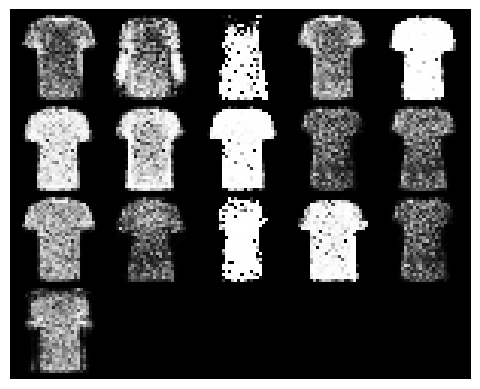

  0%|          | 0/188 [00:00<?, ?it/s]

Random fake image examples for: Trouser


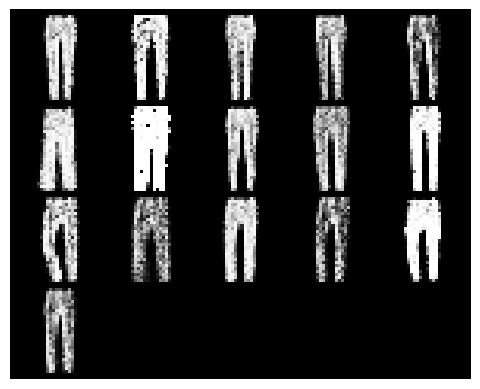

  0%|          | 0/188 [00:00<?, ?it/s]

Random fake image examples for: Pullover


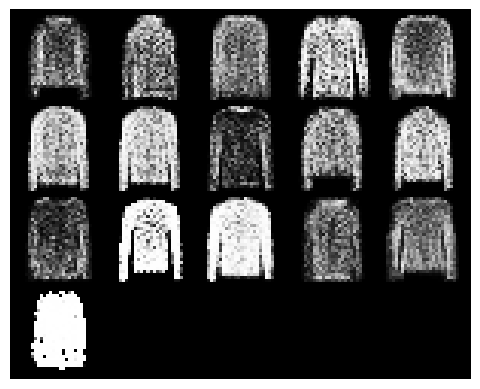

  0%|          | 0/188 [00:00<?, ?it/s]

Random fake image examples for: Dress


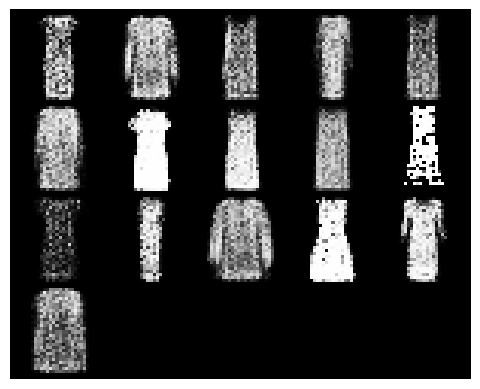

  0%|          | 0/188 [00:00<?, ?it/s]

Random fake image examples for: Coat


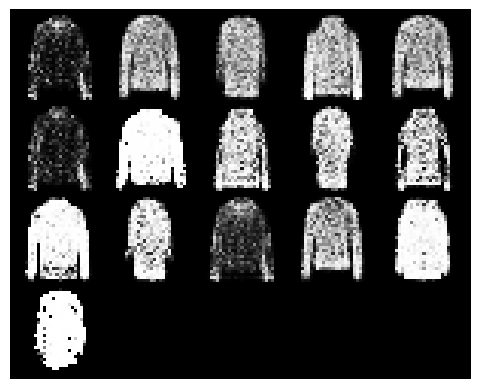

  0%|          | 0/188 [00:00<?, ?it/s]

Random fake image examples for: Sandal


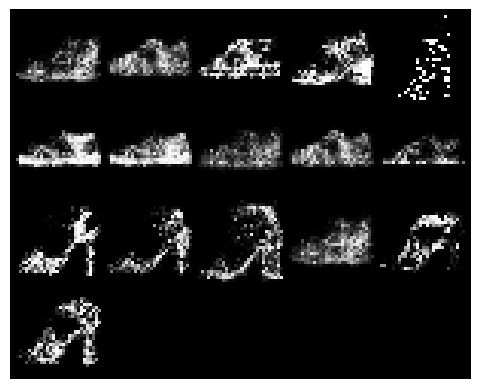

  0%|          | 0/188 [00:00<?, ?it/s]

Random fake image examples for: Shirt


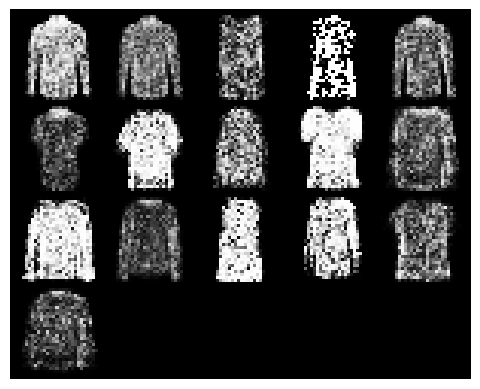

  0%|          | 0/188 [00:00<?, ?it/s]

Random fake image examples for: Sneaker


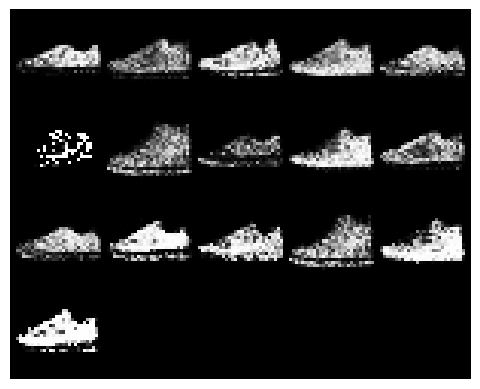

  0%|          | 0/188 [00:00<?, ?it/s]

Random fake image examples for: Bag


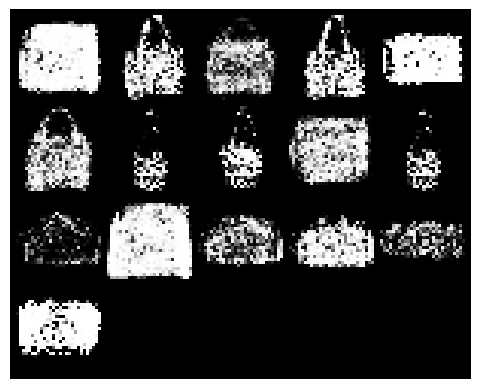

  0%|          | 0/188 [00:00<?, ?it/s]

Random fake image examples for: Ankle boot


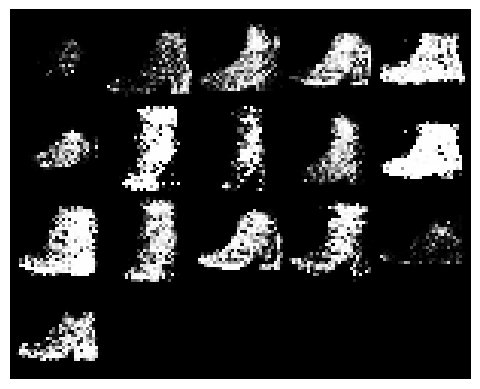

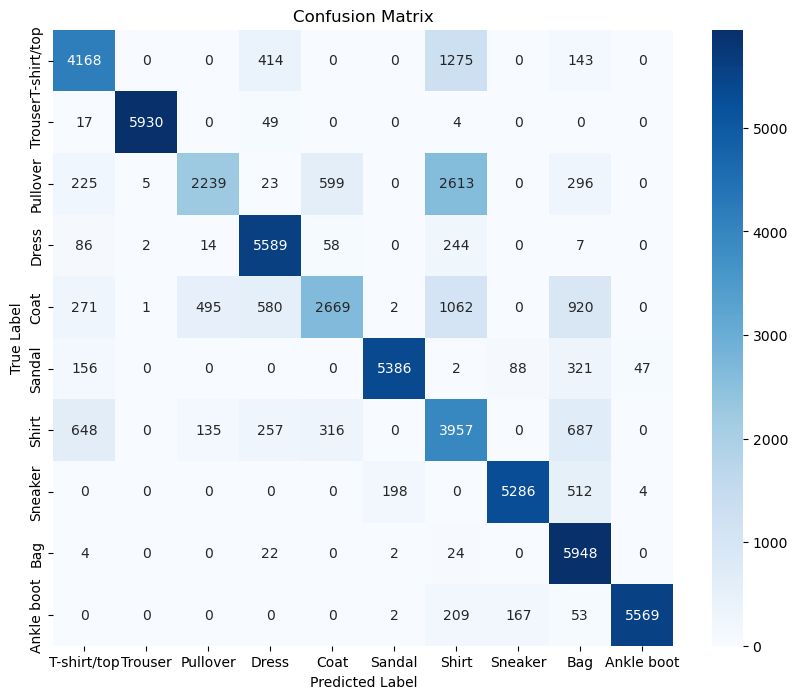


Classification Summary:
Class-wise Accuracy:
T-shirt/top: 69.47%
Trouser: 98.83%
Pullover: 37.32%
Dress: 93.15%
Coat: 44.48%
Sandal: 89.77%
Shirt: 65.95%
Sneaker: 88.10%
Bag: 99.13%
Ankle boot: 92.82%


In [22]:
models = Models()
models.run_classification()

In [11]:
class Models_cGAN:
    def __init__(self):
        self.conditional_gan_path = Path("FashionMNIST_cGAN/models")
        self.classifier_model_path = Path("Issue_Generate_Predictor/models")
        self.accuracy_rate = 0
        self.total_predictions = 0
        self.correct_predictions = 0
        self.class_correct = [0] * 10
        self.class_total = [0] * 10
        self.all_predictions = []
        self.all_true_labels = []

    def run_classification(self):
        print("cGAN | Starting classification process...")
        self.get_generated_images()
        self.calculate_class_accuracies()
        self.print_summary()

    def get_generated_images(self):
        print("cGAN | Models | Get Generated Images")
        cGanParams = cGANGetter()
        class_data_loaders = cGanParams.get_class_data_loaders()
        gen = cGanParams.get_generator()
        device = cGanParams.device
        classification_model = self.get_classification_model()
        latent_dim = cGanParams.latent_dim

        for index in range(10):
            for real, _ in tqdm(class_data_loaders):
                path = self.conditional_gan_path / "generator.pth"
                checkpoint = torch.load(path, map_location='cpu')
                gen.load_state_dict(checkpoint)
                
                cur_batch_size = len(real)
                gen.eval()

                noise = torch.randn(cur_batch_size, latent_dim, device=device)
                labels = torch.full((cur_batch_size,), index, device=device, dtype=torch.long)

                with torch.no_grad():
                    generated_images = gen(noise, labels)
                self.perform_classification(classification_model, generated_images, index)
            print(f"Random fake image examples for: {class_names[index]}")
            show_tensor_images(generated_images)

    def get_classification_model(self):
        model = FashionCNN()
        model_path = self.classifier_model_path / "CNN_model.pth"
        model_state_dict = torch.load(model_path, map_location='cpu')
        model.load_state_dict(model_state_dict)
        return model
    
    def perform_classification(self, real_model, fake_images, true_label):
        real_model.eval()
        
        if fake_images.shape[1] == 784:
            fake_images = fake_images.view(-1, 1, 28, 28)

        with torch.no_grad():
            outputs = real_model(fake_images)
            _, predicted = torch.max(outputs.data, 1)
            self.total_predictions += len(fake_images)
            correct = (predicted == true_label).sum().item()
            self.correct_predictions += correct
            self.class_correct[true_label] += correct
            self.class_total[true_label] += len(fake_images)
            self.all_predictions.extend(predicted.cpu().numpy())
            self.all_true_labels.extend([true_label] * len(fake_images))

        self.accuracy_rate = 100 * (self.correct_predictions / self.total_predictions)

    def calculate_class_accuracies(self):
        self.class_accuracies = []
        for i in range(10):
            if self.class_total[i] > 0:
                accuracy = 100 * (self.class_correct[i] / self.class_total[i])
                self.class_accuracies.append((class_names[i], accuracy))
            else:
                self.class_accuracies.append((class_names[i], 0))
    
    def print_summary(self):
        cm = confusion_matrix(self.all_true_labels, self.all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        print("\nClassification Summary:")
        print("Class-wise Accuracy:")
        for name, accuracy in self.class_accuracies:
            print(f"{name}: {accuracy:.2f}%")

cGAN | Starting classification process...
cGAN | Models | Get Generated Images
cGan Getter | Get Class Data Loader


  0%|          | 0/938 [00:00<?, ?it/s]

c:\Users\beray\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random fake image examples for: T-shirt/top


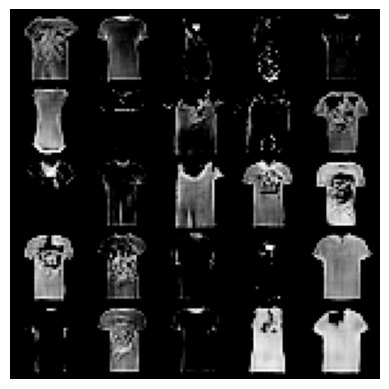

  0%|          | 0/938 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random fake image examples for: Trouser


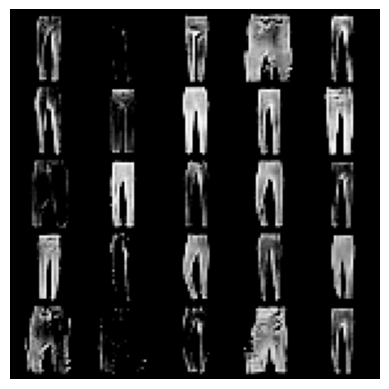

  0%|          | 0/938 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random fake image examples for: Pullover


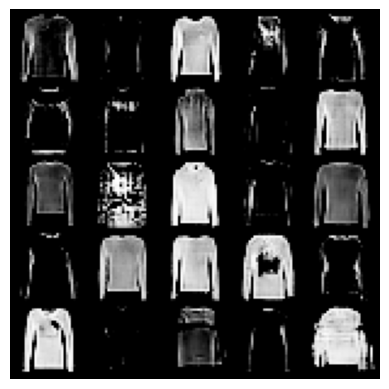

  0%|          | 0/938 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random fake image examples for: Dress


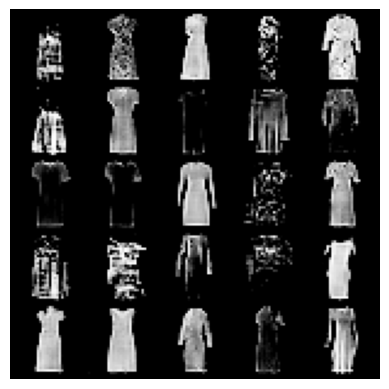

  0%|          | 0/938 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random fake image examples for: Coat


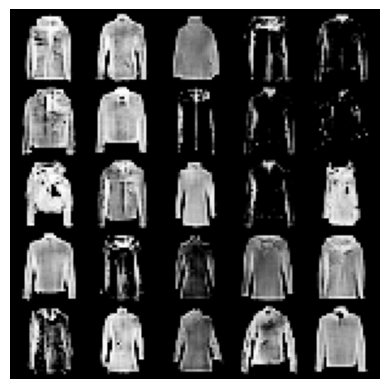

  0%|          | 0/938 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random fake image examples for: Sandal


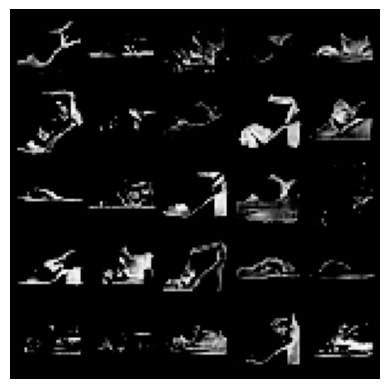

  0%|          | 0/938 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random fake image examples for: Shirt


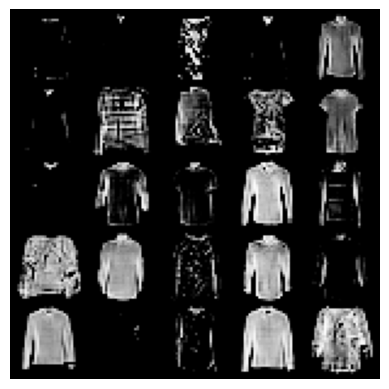

  0%|          | 0/938 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random fake image examples for: Sneaker


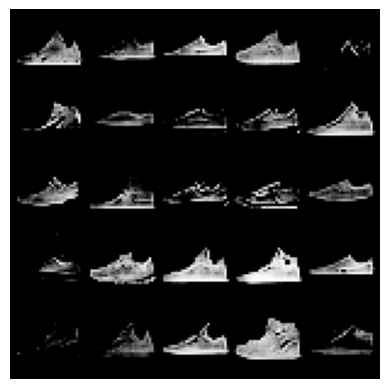

  0%|          | 0/938 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random fake image examples for: Bag


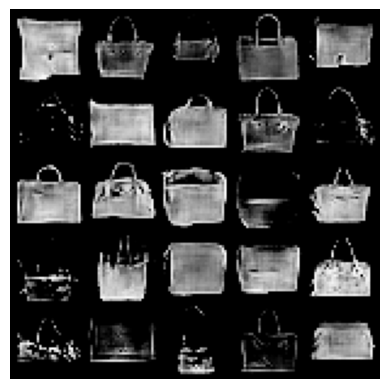

  0%|          | 0/938 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random fake image examples for: Ankle boot


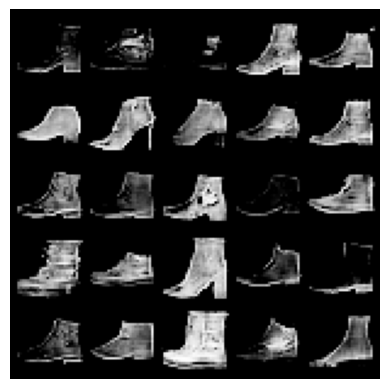

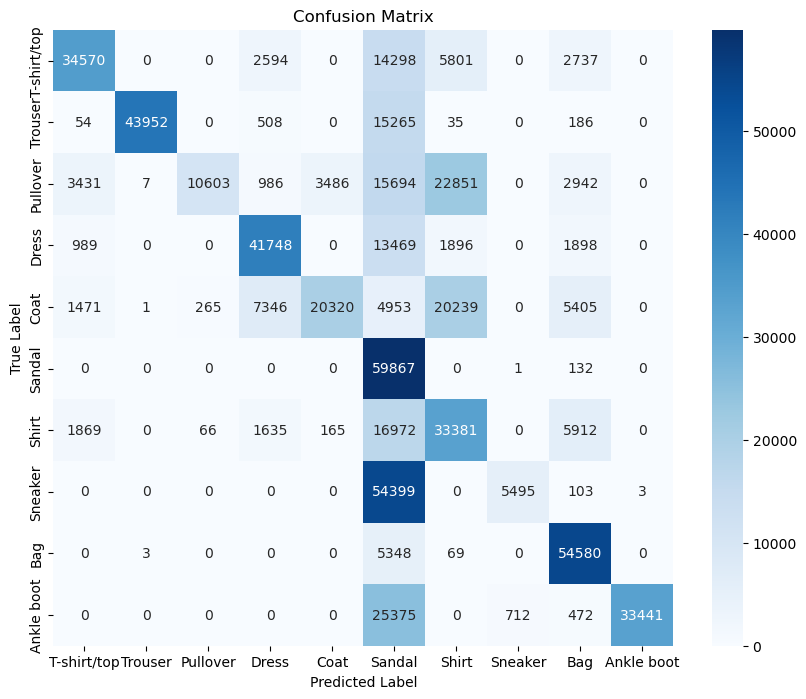


Classification Summary:
Class-wise Accuracy:
T-shirt/top: 57.62%
Trouser: 73.25%
Pullover: 17.67%
Dress: 69.58%
Coat: 33.87%
Sandal: 99.78%
Shirt: 55.63%
Sneaker: 9.16%
Bag: 90.97%
Ankle boot: 55.73%


In [12]:
modelscGAN = Models_cGAN()
modelscGAN.run_classification()